In [53]:
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
import ta
import numpy as np
import matplotlib.pyplot as plt
# Download stock data
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Calculate similarity between two time series
def calculate_similarity(current_data, past_data):
    min_length = min(len(current_data), len(past_data))
    current_data = current_data[:min_length]
    past_data = past_data[:min_length]
    
    # Normalize the data
    current_data = (current_data - np.mean(current_data)) / np.std(current_data)
    past_data = (past_data - np.mean(past_data)) / np.std(past_data)
    
    return mean_squared_error(current_data, past_data)



# Calibrate indicators
def calibrate_indicators(data, rsi_window, sma_window, ema_window,bollinger_window, stoch_window):
    data['RSI'] = ta.momentum.RSIIndicator(data['Close'], rsi_window).rsi()
    data['SMA'] = ta.trend.sma_indicator(data['Close'], sma_window)
    data['EMA'] = ta.trend.EMAIndicator(data['Close'], ema_window).ema_indicator()
    data['Bollinger'] = ta.volatility.BollingerBands(data['Close'], bollinger_window).bollinger_mavg()
    data['Stochastic'] = ta.momentum.StochasticOscillator(data['High'], data['Low'], data['Close'], stoch_window).stoch()



def find_similar_periods(ticker, current_start_date, current_end_date, past_start_year, past_end_year, step_months, top_n=5):
    current_data = get_stock_data(ticker, current_start_date, current_end_date)
    
    similar_periods = {}
    
    for year in range(past_start_year, past_end_year + 1):
        for month in range(1, 13, step_months):
            start_date = pd.Timestamp(year=year, month=month, day=1)
            end_date = start_date + pd.DateOffset(months=3)  # Do not subtract 1 day
            
            if end_date > current_end_date:
                continue
            
            try:
                past_data = get_stock_data(ticker, start_date, end_date)
                similarity_score = calculate_similarity(current_data['Close'], past_data['Close'])
                similar_periods[(start_date, end_date)] = similarity_score
            except Exception as e:
                print(f"Failed to get data for period {start_date} to {end_date}: {e}")
    
    ranked_periods = sorted(similar_periods.items(), key=lambda x: x[1])
    
    return ranked_periods[:top_n]


def calculate_profit(actual_data, predicted_data,indicator):
    # use plot to show the actual and predicted data
    plt.title(indicator)
    plt.plot(actual_data, label='Actual')
    plt.plot(predicted_data, label='Predicted')
    plt.legend()
    plt.show()

    # Remove pairs where the predicted data is NaN
    actual_data = [actual for actual, predicted in zip(actual_data, predicted_data) if not np.isnan(predicted)]
    predicted_data = [predicted for predicted in predicted_data if not np.isnan(predicted)]
    

  
    # Calculate the difference between the predicted price and the actual price
    difference = np.array(predicted_data) - np.array(actual_data)
    
    # If the predicted price is higher than the actual price, it means a loss
    # If the predicted price is lower than the actual price, it means a profit
    # Sum up all the differences to get the total profit or loss
    total_profit_or_loss = sum(difference)
    
    return total_profit_or_loss


# Predict prices using the single-period SMA
def predict_prices(data, sma_window):
    data['SMA'] = ta.trend.sma_indicator(data['Close'], sma_window)
    predicted_prices = data['SMA']  # Use the single-period SMA directly
    return predicted_prices


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

The 1st most similar year period is: (Timestamp('2016-04-01 00:00:00'), Timestamp('2016-07-01 00:00:00'))


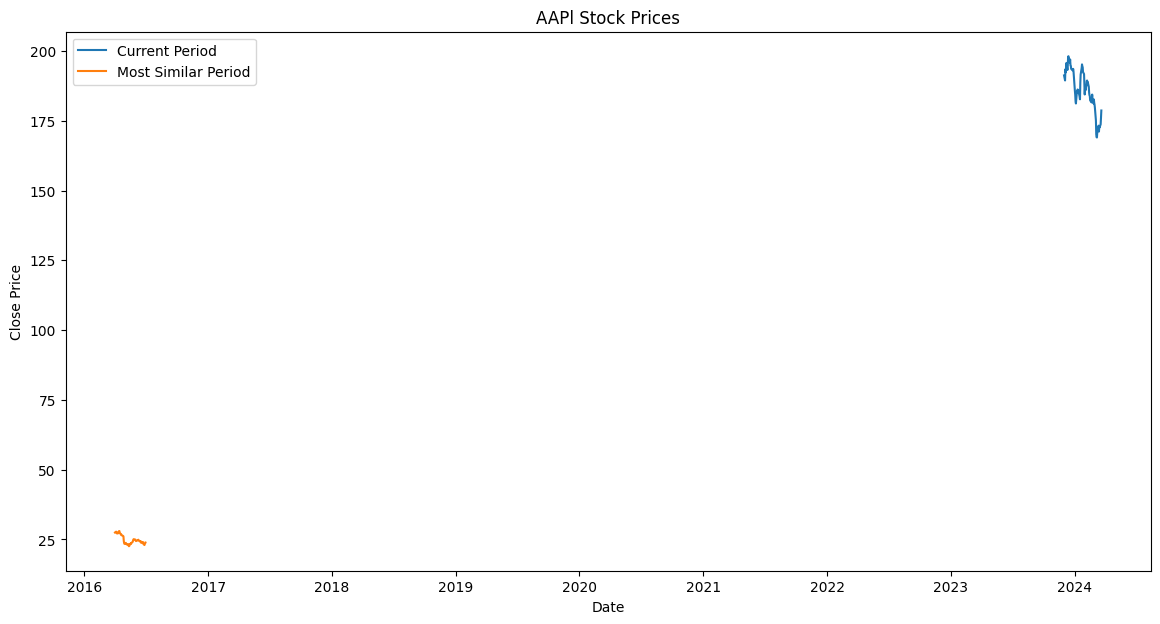

The 2nd most similar year period is: (Timestamp('2018-10-01 00:00:00'), Timestamp('2019-01-01 00:00:00'))
The 3rd most similar year period is: (Timestamp('2023-07-01 00:00:00'), Timestamp('2023-10-01 00:00:00'))
The 4th most similar year period is: (Timestamp('2022-04-01 00:00:00'), Timestamp('2022-07-01 00:00:00'))
The 5th most similar year period is: (Timestamp('2015-07-01 00:00:00'), Timestamp('2015-10-01 00:00:00'))


In [54]:
# Example usage
ticker_symbol = input("Enter the ticker symbol: ")
# The current_start and current_end should be user input
current_start = pd.Timestamp(year=2023, month=12, day=1)
current_end = pd.Timestamp(year=2024, month=3, day=21)
past_start_year = 2014
past_end_year = 2024
step_months = 3

similar_periods = find_similar_periods(ticker_symbol, current_start, current_end, past_start_year, past_end_year, step_months)
for i, period in enumerate(similar_periods, 1):
    print(f"The {i}{'' if i == 0 else 'st' if i == 1 else 'nd' if i == 2 else 'rd' if i == 3 else 'th'} most similar year period is:", period[0])

    # The most simliar period is the first period
    if ( i == 1):
         #Fetch the data for the two periods
        data_current = get_stock_data(ticker_symbol, current_start, current_end)
        # period[0][0] is the start date and period[0][1] is the end date
        data_similar = get_stock_data(ticker_symbol, period[0][0], period[0][1])

        # Plot the closing prices for the current period
        plt.figure(figsize=(14, 7))
        plt.plot(data_current.index, data_current['Close'], label='Current Period')

        # Plot the closing prices for the most similar period
        plt.plot(data_similar.index, data_similar['Close'], label='Most Similar Period')

        plt.title(f'{ticker_symbol} Stock Prices')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.show()


In [55]:
# Select the top similar period for calibration
top_period = similar_periods[0][0]
top_data = get_stock_data(ticker_symbol, top_period[0], top_period[1])


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed

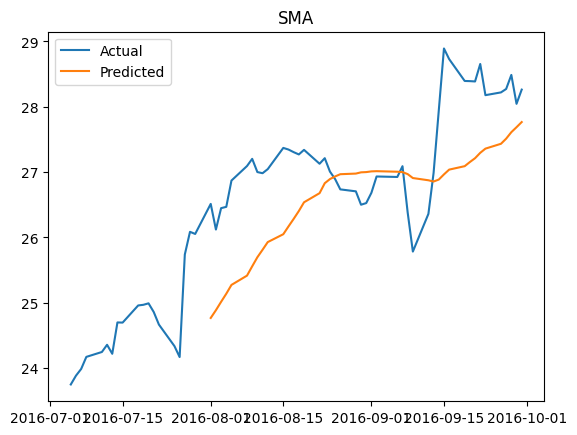

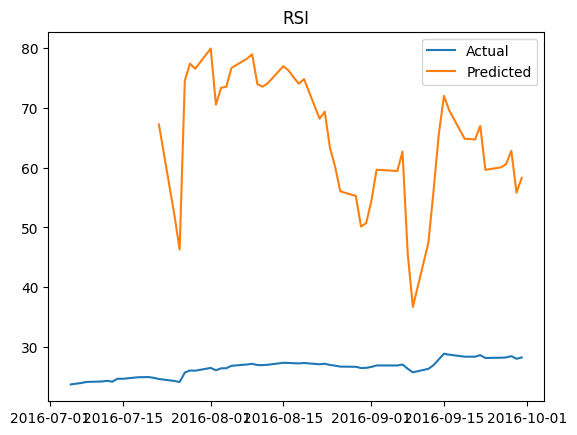

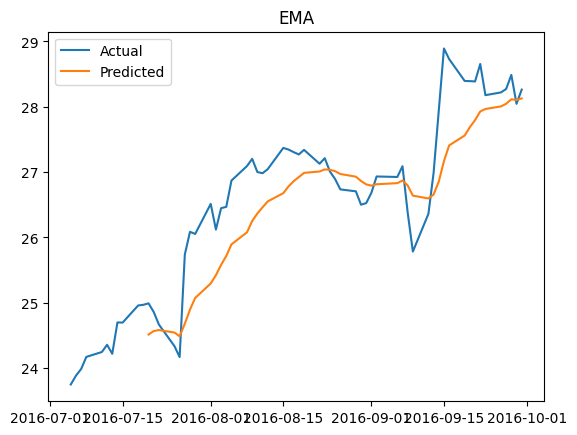

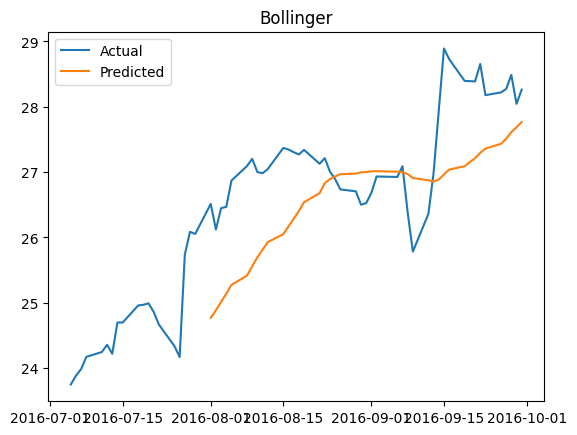

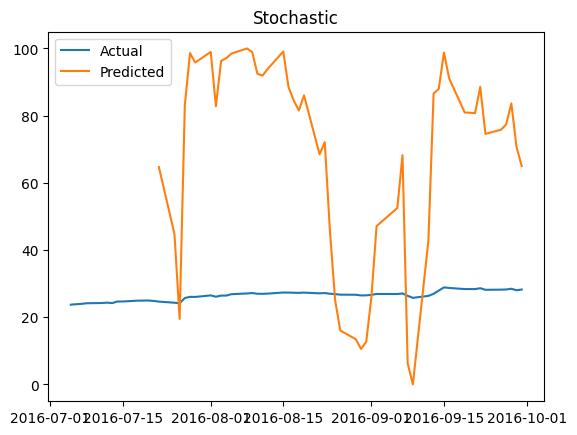

Profit with calibrated SMA: -30.24425020217896
Profit with calibrated RSI: 1893.0888958518108
Profit with calibrated EMA: -20.362900884444812
Profit with calibrated Bollinger Bands: -30.24425020217896
Profit with calibrated Stochastic Oscillator: 2095.249139569025


In [56]:
# Calibrate indicators
rsi_window = 14
sma_window = 20
ema_window = 12
bollinger_window = 20
stoch_window = 14

calibrate_indicators(top_data, rsi_window, sma_window, ema_window,bollinger_window, stoch_window)

# Evaluate performance with past future periods
future_start = top_period[1] + pd.DateOffset(days=1)
future_end = future_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)
future_data = get_stock_data(ticker_symbol, future_start, future_end)

predicted_prices = predict_prices(future_data, sma_window)
actual_prices = future_data['Close']

# Evaluate performance for SMA, EMA, MACD, RSI, Bollinger Bands, Stochastic Oscillator, and ATR
sma_profit = calculate_profit(actual_prices, predicted_prices,"SMA")

future_data['RSI'] = ta.momentum.RSIIndicator(future_data['Close'], rsi_window).rsi()
rsi_profit = calculate_profit(actual_prices, future_data['RSI'],"RSI")
future_data['EMA'] = ta.trend.EMAIndicator(future_data['Close'], ema_window).ema_indicator()
ema_profit = calculate_profit(actual_prices, future_data['EMA'],"EMA")
future_data['Bollinger'] = ta.volatility.BollingerBands(future_data['Close'], bollinger_window).bollinger_mavg()
bollinger_profit = calculate_profit(actual_prices, future_data['Bollinger'],"Bollinger")
future_data['Stochastic'] = ta.momentum.StochasticOscillator(future_data['High'], future_data['Low'], future_data['Close'], stoch_window).stoch()
stoch_profit = calculate_profit(actual_prices, future_data['Stochastic'],"Stochastic")


print(f"Profit with calibrated SMA: {sma_profit}")
print(f"Profit with calibrated RSI: {rsi_profit}")
print(f"Profit with calibrated EMA: {ema_profit}")
print(f"Profit with calibrated Bollinger Bands: {bollinger_profit}")
print(f"Profit with calibrated Stochastic Oscillator: {stoch_profit}")
